# Students Details:
* Guy Kabiri 312252224
* Tomer Dwek 313229486
* Tal Goldengoren 207042573


# Model Summarization

## U–Net
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)  
The `U-Net` is a CNN architecture for fast and precise segmentation of images.  
It has outperformed the prior best methods of segmentation in several challenges.  
This network consists of a contracting path and an expansive path that fives its shape.
The contracting path consists of repeated application of convolutions followed by a `ReLU` and max pooling.
The expansive path combines feature and spatial information through a sequence of convolutions and concatenations with high-resolution features from the contracting path..

## FPN
![](https://paperswithcode.com/media/methods/new_teaser_TMZlD2J.jpg)  
Feature Pyramid Network is a feature extractor that takes a single image and outputs proportionally sized feature maps at multiple levels.  
It acts as a generic solution for building feature pyramids inside deep convolutional networks to be used in tasks like object detection.  
The construction of the pyramid involves a bottom-up pathway and a top-down pathway.  
The bottom-up path is a feedforward computation of the `ConvNet`.  
The top-down path hallucinates higher resolution features by upsampling spatially coarser.

## PAN
![](https://github.com/oyam/PanNet-Landsat/blob/master/imgs/architecture.png?raw=true)  
`PanNet` is a deep network architecture designed to solve the sharpening problem.  Pan sharpening is a radiometric transformation available through a raster function or from a geoprocessing tool. Several image companies provide low-resolution, multi-band images and higher-resolution, panchromatic images of the same scenes.
Panetta is focusing on the two aims of the pan-sharpening problem: `spectral` and `spatial` preservation.

## DeepLabV3
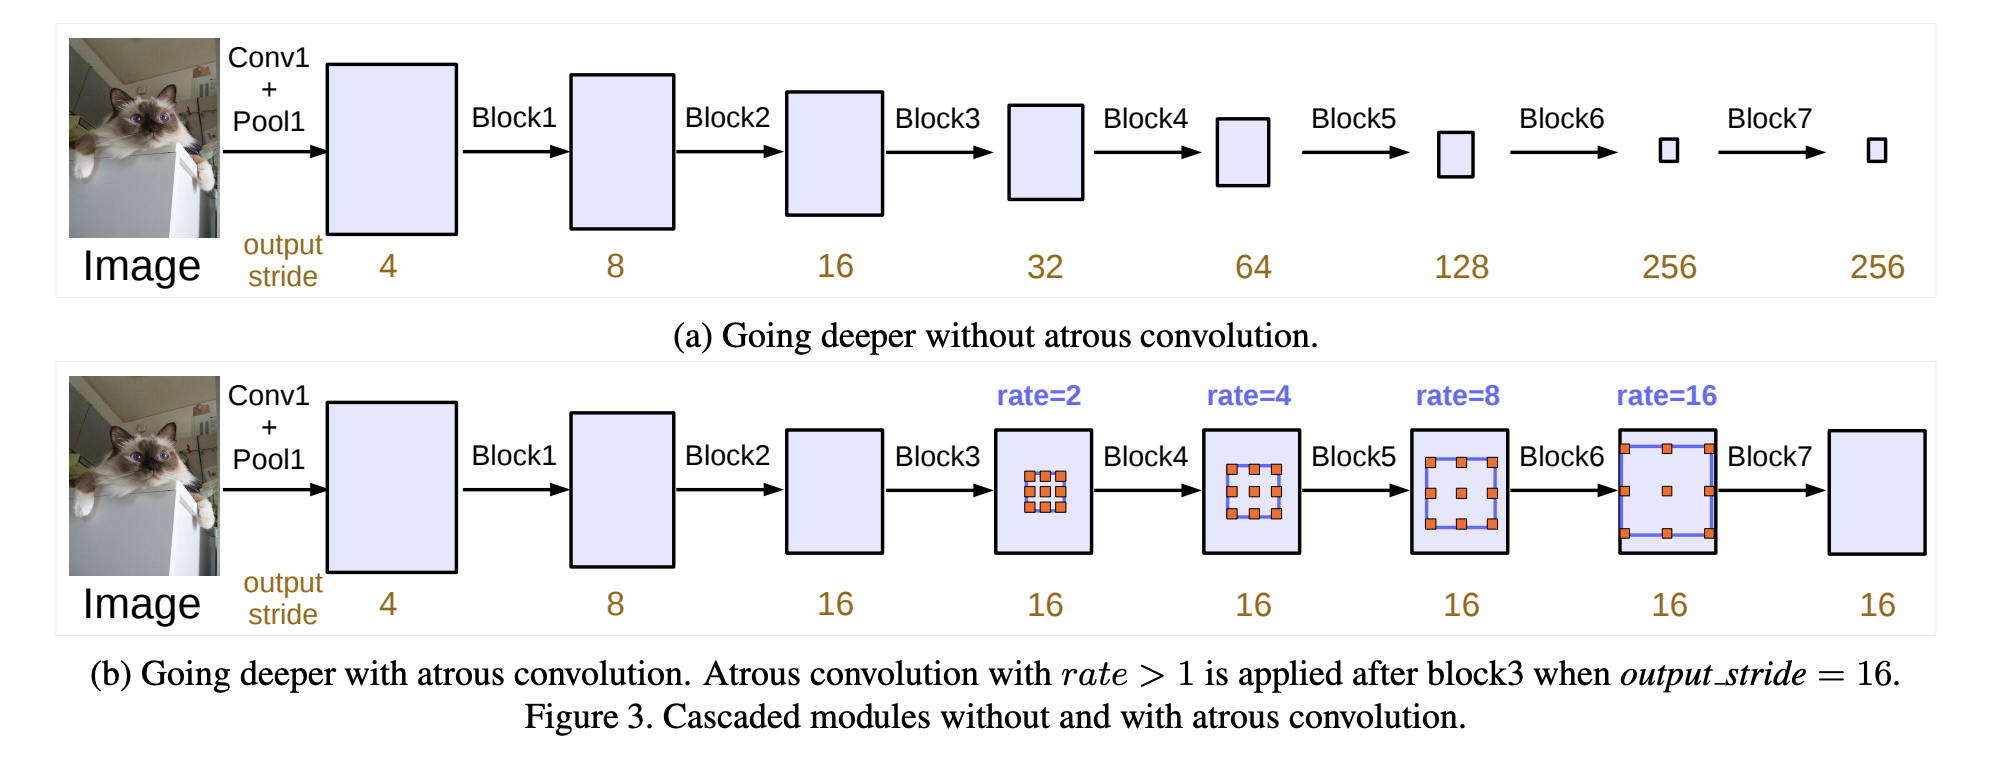  
`DeepLabV3` is a semantic segmentation architecture. It handles the problem of segmenting objects at multiple scales by modules that are designed to employ atrous convolution in cascade to capture multi-scale context by adopting multiple atrous rates.  
Atrous Convolution:
For each location `i` on the output `y` and a filter `w`, atrous convolution is applied over the input feature map `x` where the atrous rate `r` corresponds to the stride with which we sample the input signal.  
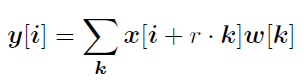  
![](https://miro.medium.com/max/1130/1*-r7CL0AkeO72MIDpjRxfog.png) 

# Lab Session

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
!pip install torchmetrics timm
import torchmetrics 

     |████████████████████████████████| 287 kB 1.3 MB/s eta 0:00:01


In [3]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 66 kB 826 kB/s eta 0:00:01
     |████████████████████████████████| 244 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.5 MB/s eta 0:00:011
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=2fb45580cd21681ed1f5ddcdf1b3e4838f06dce26b617aace3be0ae29087ec1e
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=e5c4e92ab1dc060e926e632ce4ee6ce22ef9532ec4558355314be27ce7a44911
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing installation: timm 0.4.5
    Uninstalling timm-0.4.5:
      Successfully uninstalled timm-0.4.5


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Mask Decoder Function

In [5]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [6]:
def rle_encode(img):
    dots = np.where(img.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(str(x) for x in run_lengths)    

## Dataset and Dataloder

In [7]:
class AirebusShipDataset(Dataset):
    def __init__(self, path, data, masks=None, transforms=None):
        super(AirebusShipDataset, self).__init__()

        self.path = path
        self.x = data
        self.y = masks
        self.transforms = transforms

    def __getitem__(self, idx):
        imgId = self.x[idx]
        img_path = self.path + '/' + imgId
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        msk = self.y.loc[self.y['ImageId'] == imgId, 'EncodedPixels'].tolist()

        all_masks = np.zeros((768, 768))

        if not pd.isna(msk).any():
            for mask in msk:
                all_masks += rle_decode(mask)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=all_masks)
            img = transformed['image']
            all_masks = transformed['mask']
            
        img = np.transpose(img, (2, 0, 1))
            
        return img, all_masks

    def __len__(self):
        return len(self.x)

In [8]:
def get_paths(data_path, split=1, drop_rate=0):
    all_paths  = os.listdir(data_path)
    np.random.shuffle(all_paths)

    if drop_rate > 0:
        all_paths = all_paths[:int(len(all_paths) * (1 - drop_rate))]

    if split != 1:
        l = len(all_paths)
        np.random.shuffle(all_paths)
        top = int(l*split)
        train = all_paths[:top]
        test = all_paths[top:]
        return train, test
    return all_paths

In [9]:
path = '../input/airbus-ship-detection'
train_csv = pd.read_csv(path + '/train_ship_segmentations_v2.csv')
masks = pd.DataFrame(train_csv)

data_path = path + '/train_v2'

In [10]:
train_paths, valid_paths = get_paths(data_path, 0.7, drop_rate=0.99)

print(f'In this training set we have got a total of {len(train_paths)}')
print(f'In this validation set we have got a total of {len(valid_paths)}')

In this training set we have got a total of 1347
In this validation set we have got a total of 578


In [11]:
transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

In [12]:
trainset = AirebusShipDataset(data_path, train_paths, masks, transforms=None)
validset = AirebusShipDataset(data_path, valid_paths, masks, transforms=None)

In [13]:
batch_size = 10

In [14]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

## Visualiztion Functions

In [15]:
def plot_graphs(t_loss, t_accuracy, v_loss, v_accuracy):
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(t_loss, label='Train', color='orange')
    plt.plot(v_loss, label='Validation', color='royalblue')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(t_accuracy, label='Train', color='orange')
    plt.plot(v_accuracy, label='Validation', color='royalblue')
    plt.legend()
    
    plt.show()

In [16]:
def show_samples(loader, model=None):
    img_batch, msk_batch = next(iter(loader))
    for index, img, msk in zip(range(5), img_batch, msk_batch):
        if model:
            fig, axarr = plt.subplots(1, 3, figsize=(8, 20))
        else:
            fig, axarr = plt.subplots(1, 2, figsize=(8, 20))
        
        for ax in axarr:
            ax.axis('off')
        
        if model:
            with torch.no_grad():
                img_for_model = img[np.newaxis, :, :, :].float().to(device)
                output = model(img_for_model)
                output = np.transpose(output.cpu().numpy()[0], (1, 2, 0))
                axarr[2].imshow(output, cmap='gray')
                axarr[2].set_title('Output')
                
        img = np.transpose(img.cpu(), (1, 2, 0))
        axarr[0].imshow(img)
        axarr[0].set_title('Image')
        axarr[1].imshow(msk, cmap='gray')
        axarr[1].set_title('Mask')
            
        plt.tight_layout(h_pad=0.1, w_pad=0.1)
        plt.show()

## Training Samples

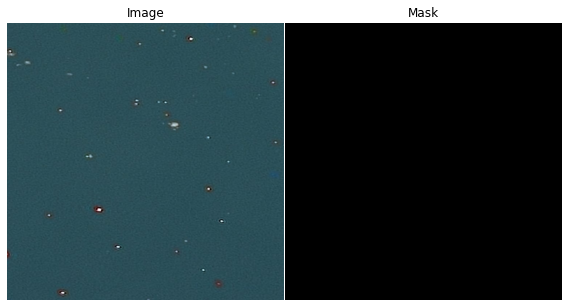

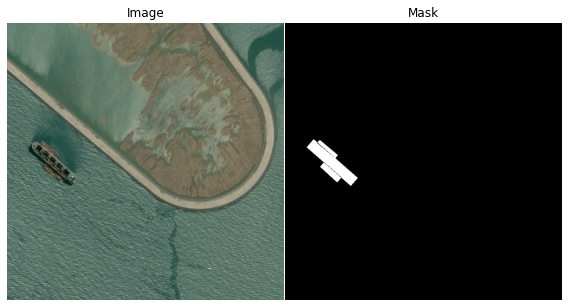

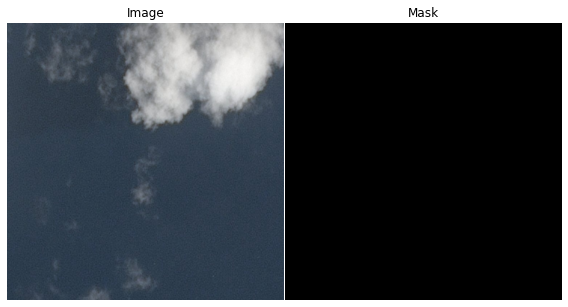

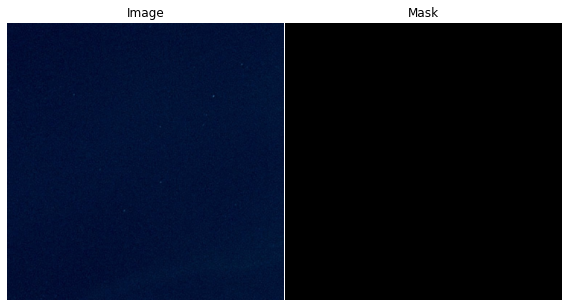

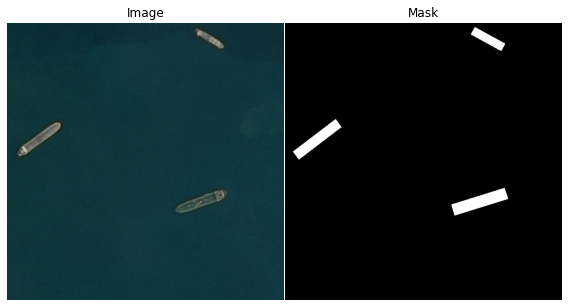

In [17]:
show_samples(trainloader)

## Dice Loss

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Save And Load Model Functions

In [20]:
def save_model(model, optimizer, epoch, loss, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
  
def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

## Train and Validation Functions

In [21]:
def train(loader, model, optimizer, criterion, epoch):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.train()

    with tqdm(total=len(loader), desc='Train') as progress_bar:
        for (x_batch, y_batch) in loader:
            x_batch = x_batch.float().to(device)  
            y_batch = y_batch.long().to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            output = F.softmax(output, dim=0)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            acc = torchmetrics.functional.accuracy(output, y_batch)

            losses.update(loss.item(), x_batch.size(0))
            accuracy.update(acc, x_batch.size(0))
            
            del x_batch
            del y_batch
            torch.cuda.empty_cache()
            progress_bar.update(1)

    return losses.avg, accuracy.avg

In [22]:
def validation(loader, model, criterion, epoch):
    accuracy = AverageMeter()
    losses = AverageMeter()
    model.eval()

    with tqdm(total=len(loader), desc='Valid') as progress_bar:
        for (x_batch, y_batch) in loader:
            with torch.no_grad():
                x_batch = x_batch.float().to(device)    
                y_batch = y_batch.long().to(device)

                output = model(x_batch)
                output = F.softmax(output, dim=0)

                loss = criterion(output, y_batch)    

                acc = torchmetrics.functional.accuracy(output, y_batch)

                losses.update(loss.item(), x_batch.size(0))
                accuracy.update(acc, x_batch.size(0))

            del x_batch
            del y_batch
            torch.cuda.empty_cache()
            progress_bar.update(1)

    return losses.avg, accuracy.avg

In [23]:
def train_model(train_loader, valid_loader, model, optimizer, criterion, start_epoch, epochs, export_name, scheduler=None):
    torch.cuda.empty_cache()

    model = model.to(device)
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []

    best_valid_score = 0
    for epoch in range(start_epoch, start_epoch + epochs):
        train_loss, train_accuracy = train(train_loader, model, optimizer, criterion, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        
        valid_loss, valid_accuracy = validation(valid_loader, model, criterion, epoch)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_accuracy)
        
        if scheduler:
            scheduler.step()
        print('Epoch {:3d}:\ttrain loss: {:g},\ttrain accuracy: {:g},\n\t\tvalid loss: {:g},\tvalid accuracy: {:g}'.format(epoch + 1, train_loss, train_accuracy, valid_loss, valid_accuracy))

        if valid_accuracy > best_valid_score:
            path = '{}.pth'.format(export_name)
            save_model(model, optimizer, epochs, valid_loss, path)
            
    return train_losses, train_accs, valid_losses, valid_accs

## Training

### U-Model

In [24]:
experiment_u_model = 0

In [25]:
u_model = smp.Unet(
    encoder_name='resnet34',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [26]:
experiment_u_model += 1
start_epoch = 0
epochs = 10
criterion = DiceLoss()
optimizer = optim.AdamW(u_model.parameters())

In [27]:
%%time
train_losses, train_accs, valid_losses, valid_accs = train_model(trainloader, validloader, u_model, optimizer, criterion, start_epoch, epochs, 'unet')

Valid: 100%|██████████| 58/58 [00:56<00:00,  1.02it/s]


Epoch   1:	train loss: 0.982737,	train accuracy: 0.928023,
		valid loss: 0.987546,	valid accuracy: 0.91876


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch   2:	train loss: 0.979644,	train accuracy: 0.916343,
		valid loss: 0.983559,	valid accuracy: 0.947201


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch   3:	train loss: 0.979167,	train accuracy: 0.913534,
		valid loss: 0.98324,	valid accuracy: 0.912194


Valid: 100%|██████████| 58/58 [00:52<00:00,  1.11it/s]


Epoch   4:	train loss: 0.979048,	train accuracy: 0.91831,
		valid loss: 0.982399,	valid accuracy: 0.956722


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch   5:	train loss: 0.978437,	train accuracy: 0.91222,
		valid loss: 0.982088,	valid accuracy: 0.91768


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch   6:	train loss: 0.979242,	train accuracy: 0.911092,
		valid loss: 0.98278,	valid accuracy: 0.917898


Valid: 100%|██████████| 58/58 [00:51<00:00,  1.13it/s]


Epoch   7:	train loss: 0.979217,	train accuracy: 0.908357,
		valid loss: 0.982866,	valid accuracy: 0.910352


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.15it/s]


Epoch   8:	train loss: 0.978875,	train accuracy: 0.909545,
		valid loss: 0.981692,	valid accuracy: 0.910585


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


Epoch   9:	train loss: 0.978196,	train accuracy: 0.905332,
		valid loss: 0.982839,	valid accuracy: 0.913563


Valid: 100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


Epoch  10:	train loss: 0.978555,	train accuracy: 0.911058,
		valid loss: 0.983175,	valid accuracy: 0.919846
CPU times: user 33min 8s, sys: 19min 47s, total: 52min 56s
Wall time: 53min 25s


#### Results

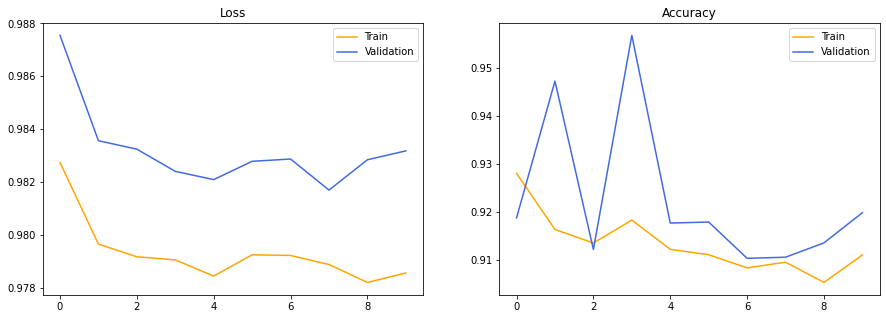

In [28]:
plot_graphs(train_losses, train_accs, valid_losses, valid_accs)

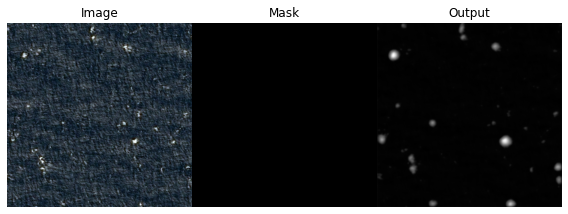

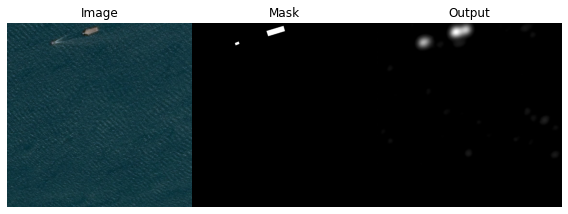

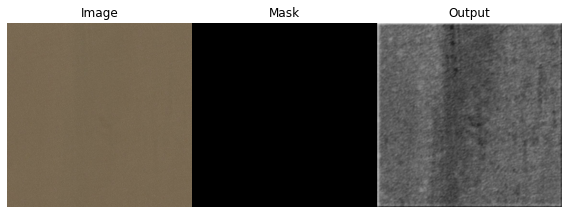

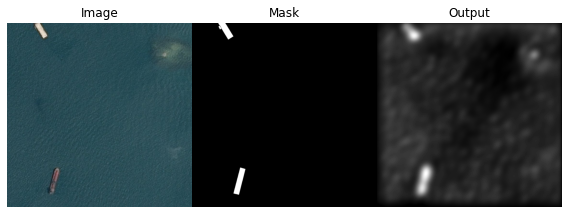

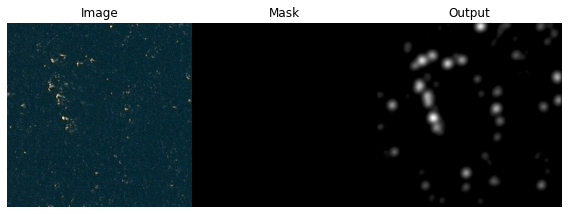

In [71]:
show_samples(validloader, u_model)

### FPN

In [30]:
experiment_fpn_model = 0

In [31]:
fpn_model = smp.FPN(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
)

In [32]:
experiment_fpn_model += 1
start_epoch = 0
epochs = 10
criterion = DiceLoss()
optimizer = optim.AdamW(fpn_model.parameters())

In [33]:
%%time
train_losses, train_accs, valid_losses, valid_accs = train_model(trainloader, validloader, fpn_model, optimizer, criterion, start_epoch, epochs, 'fpn')

Valid: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch   1:	train loss: 0.982676,	train accuracy: 0.90902,
		valid loss: 0.983635,	valid accuracy: 0.914116


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch   2:	train loss: 0.98007,	train accuracy: 0.907132,
		valid loss: 0.98165,	valid accuracy: 0.912641


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch   3:	train loss: 0.97852,	train accuracy: 0.907766,
		valid loss: 0.982554,	valid accuracy: 0.909801


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch   4:	train loss: 0.978673,	train accuracy: 0.90601,
		valid loss: 0.98123,	valid accuracy: 0.906453


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch   5:	train loss: 0.979051,	train accuracy: 0.905156,
		valid loss: 0.981937,	valid accuracy: 0.905179


Valid: 100%|██████████| 58/58 [00:43<00:00,  1.34it/s]


Epoch   6:	train loss: 0.9787,	train accuracy: 0.905409,
		valid loss: 0.981793,	valid accuracy: 0.916176


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch   7:	train loss: 0.978463,	train accuracy: 0.908142,
		valid loss: 0.981756,	valid accuracy: 0.920302


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch   8:	train loss: 0.978199,	train accuracy: 0.909963,
		valid loss: 0.983632,	valid accuracy: 0.908414


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch   9:	train loss: 0.979947,	train accuracy: 0.906634,
		valid loss: 0.984325,	valid accuracy: 0.905323


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch  10:	train loss: 0.980252,	train accuracy: 0.90604,
		valid loss: 0.984153,	valid accuracy: 0.910956
CPU times: user 26min 35s, sys: 12min 31s, total: 39min 6s
Wall time: 39min 11s


#### Results

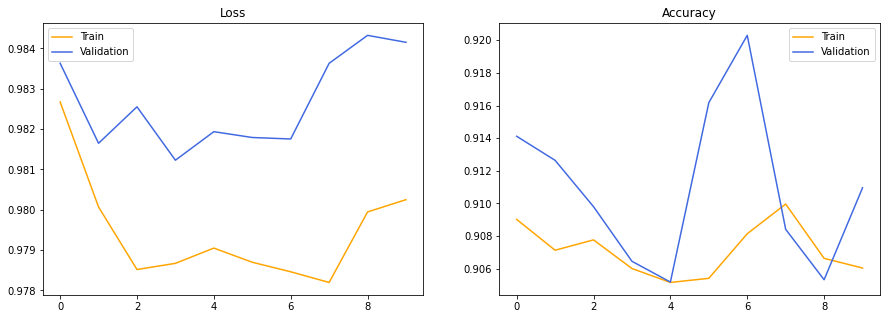

In [34]:
plot_graphs(train_losses, train_accs, valid_losses, valid_accs)

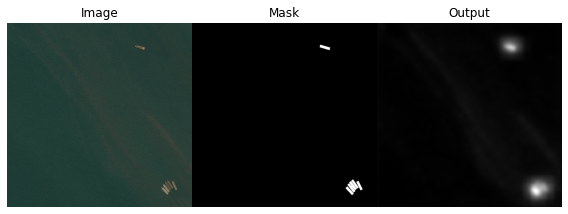

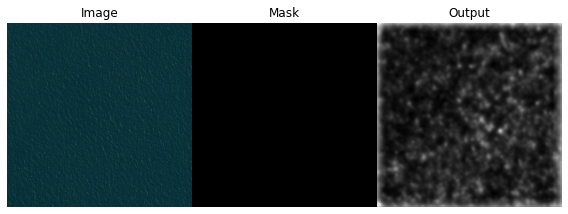

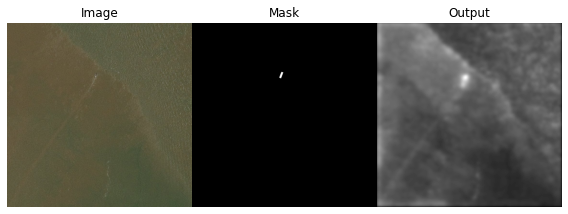

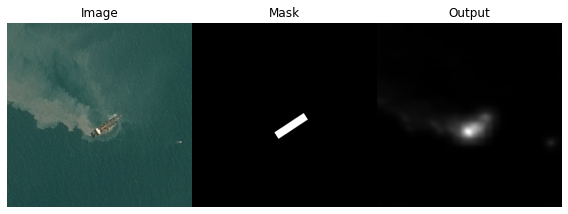

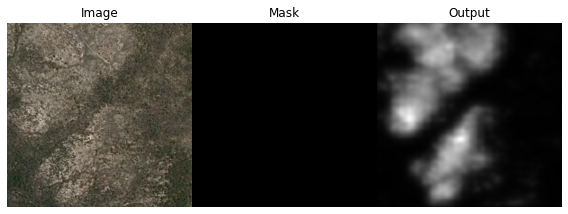

In [62]:
show_samples(validloader, fpn_model)

### PAN

In [36]:
experiment_pan_model = 0

In [37]:
pan_model = smp.PAN(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
)

In [38]:
experiment_pan_model += 1

In [39]:
start_epoch = 0
epochs = 10
criterion = DiceLoss()
optimizer = optim.AdamW(pan_model.parameters())

In [40]:
%%time
train_losses, train_accs, valid_losses, valid_accs = train_model(trainloader, validloader, pan_model, optimizer, criterion, start_epoch, epochs, 'pan')

Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch   1:	train loss: 0.982398,	train accuracy: 0.916979,
		valid loss: 0.985151,	valid accuracy: 0.917945


Valid: 100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch   2:	train loss: 0.978961,	train accuracy: 0.915568,
		valid loss: 0.981971,	valid accuracy: 0.919941


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch   3:	train loss: 0.978632,	train accuracy: 0.908889,
		valid loss: 0.982423,	valid accuracy: 0.905795


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch   4:	train loss: 0.978127,	train accuracy: 0.907486,
		valid loss: 0.981239,	valid accuracy: 0.9116


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch   5:	train loss: 0.97769,	train accuracy: 0.909053,
		valid loss: 0.982624,	valid accuracy: 0.905724


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch   6:	train loss: 0.978125,	train accuracy: 0.907275,
		valid loss: 0.981447,	valid accuracy: 0.910179


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch   7:	train loss: 0.977306,	train accuracy: 0.906228,
		valid loss: 0.98195,	valid accuracy: 0.911252


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch   8:	train loss: 0.977685,	train accuracy: 0.908217,
		valid loss: 0.980999,	valid accuracy: 0.913222


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch   9:	train loss: 0.97775,	train accuracy: 0.909053,
		valid loss: 0.982469,	valid accuracy: 0.902806


Valid: 100%|██████████| 58/58 [00:41<00:00,  1.39it/s]


Epoch  10:	train loss: 0.978218,	train accuracy: 0.906902,
		valid loss: 0.98133,	valid accuracy: 0.912178
CPU times: user 55min 31s, sys: 33min 55s, total: 1h 29min 26s
Wall time: 1h 29min 36s


#### Results

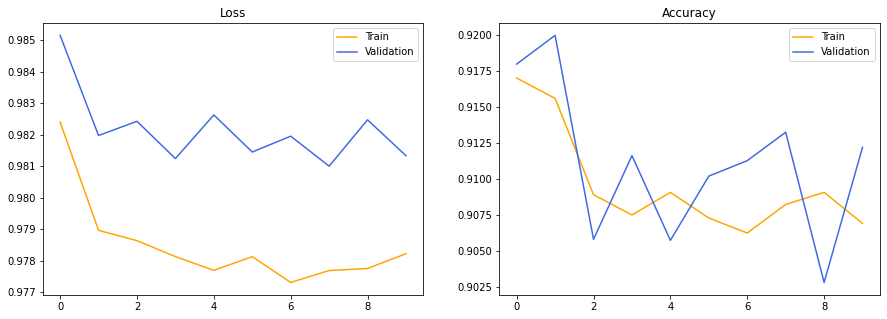

In [41]:
plot_graphs(train_losses, train_accs, valid_losses, valid_accs)

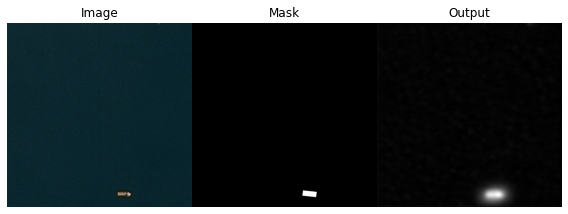

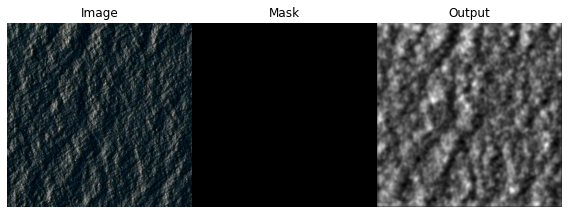

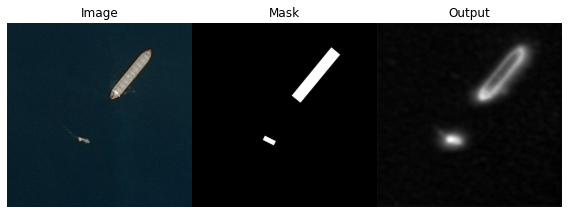

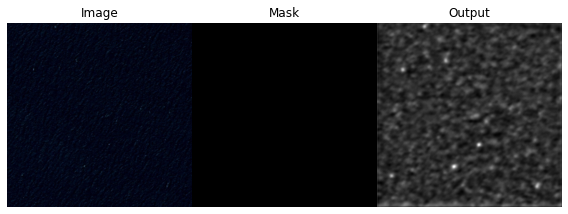

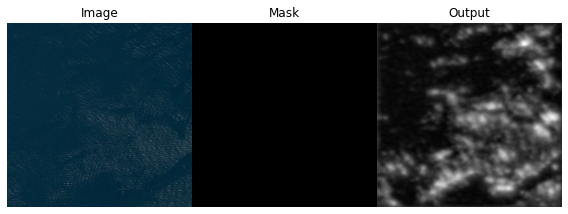

In [60]:
show_samples(validloader, pan_model)

## Test

In [50]:
def test_model(model, data_path, images):
    torch.cuda.empty_cache()
    model.eval()
    model = model.to(device)

    all_preds = []

    with tqdm(total=len(images), desc='Test') as progress_bar:
        for img_path in images:
            full_path = os.path.join(data_path, img_path)
            img = cv2.cvtColor(cv2.imread(full_path), cv2.COLOR_BGR2RGB)
            with torch.no_grad():
                img = np.transpose(img, (2,1,0))
                img = torch.tensor(img[np.newaxis, :, :, :])

                img = img.float().to(device)           

                img = model(img)
                img = torch.sigmoid(img).to('cpu').numpy()
                mask = rle_encode(img)
                
                all_preds.append(mask)
            
            del img
            torch.cuda.empty_cache()                
            progress_bar.update(1)

    return all_preds

In [51]:
path = '../input/airbus-ship-detection'
data_path = path + '/test_v2'
test_images = os.listdir(data_path)

print(f'In this testing set we have got a total of {len(test_images)}')

In this testing set we have got a total of 15606


In [52]:
u_model_res = test_model(u_model, data_path, test_images)

Test: 100%|██████████| 15606/15606 [19:54<00:00, 13.07it/s]


In [53]:
submission = pd.DataFrame({
        "ImageId": test_images,
        "EncodedPixels": u_model_res
    })
submission.to_csv('submission1.csv', index=False)

In [54]:
fpn_model_res = test_model(fpn_model, data_path, test_images)

Test: 100%|██████████| 15606/15606 [14:23<00:00, 18.08it/s]


In [55]:
submission = pd.DataFrame({
        "ImageId": test_images,
        "EncodedPixels": fpn_model_res
    })
submission.to_csv('submission2.csv', index=False)

In [56]:
pan_model_res = test_model(pan_model, data_path, test_images)

Test: 100%|██████████| 15606/15606 [13:17<00:00, 19.57it/s]


In [57]:
submission = pd.DataFrame({
        "ImageId": test_images,
        "EncodedPixels": pan_model_res
    })
submission.to_csv('submission3.csv', index=False)

## Submissions

### U-Net
![unet](https://user-images.githubusercontent.com/52006798/118357158-59fb9280-b581-11eb-8c77-234c7cc8f6a6.png)

### FPN
![fpn](https://user-images.githubusercontent.com/52006798/118357139-45b79580-b581-11eb-8453-7f6013420148.png)

### PAN
![pan](https://user-images.githubusercontent.com/52006798/118357143-48b28600-b581-11eb-8306-6e72b6456d91.png)